In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord
import os
import numpy as np
import specsim.simulator
from speclite import filters
from speclite import redshift
from astropy.constants import h, c, k_B, sigma_sb
from astropy.cosmology import Planck18
from astropy.table import Table, join
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import bed
from bed.grid import Grid, PermutationInvariant
from bed.design import ExperimentDesigner
from bed.grid import TopHat
import galsim

# local imports
from lsstetc import ETC, fiducial_nvisits
from functions import *

In [3]:
def create_grids(filters_list, design_step=2, num_parameters=102, num_features=101, design_range=30, constraint=False):
    # Define the number of visits corresponding to each filter using the fiducial number of visits
    design_ranges = {}
    for f in filters_list:
        fid_val = fiducial_nvisits[f]
        lower = int(np.round((fid_val - design_range) / design_step) * design_step)
        upper = int(np.round((fid_val + design_range) / design_step) * design_step)
        design_ranges[f'n_{f}'] = np.arange(lower, upper, design_step)

    # Create constraint: sum of all filter visits equals sum of fiducial visits
    if constraint:
        # Calculate total fiducial visits
        total_fid = sum(fiducial_nvisits[f] for f in filters_list)
        print("Constraining the total number of visits to be", total_fid)
        
        # Build constraint function dynamically with explicit parameter names
        # e.g., "lambda n_r, n_i, n_z: n_r + n_i + n_z == 524"
        constraint_func = lambda **kwargs: sum(kwargs.values()) == total_fid

        designs = Grid(**design_ranges, constraint=constraint_func)
    else:
        designs = Grid(**design_ranges)

    # Define the redshift values
    parameters = Grid(z=np.linspace(0.1, 1.0, num_parameters))

    feature_ranges = {}
    for f in filters_list:
        mag_f = M_b(parameters.z, f)
        feature_ranges[f'mag_{f}'] = np.linspace(mag_f.min() - 0.5, mag_f.max() + 0.5, num_features)

    features = Grid(**feature_ranges)

    print("Grid objects:")
    print("parameters:", parameters.shape)
    print("features:", features.shape)
    print("designs:", designs.shape)
    return parameters, features, designs

In [4]:
filters_list = ['r', 'i']
parameters, features, designs = create_grids(filters_list, design_step=5, num_parameters=102, num_features=101)

Grid objects:
parameters: (102,)
features: (101, 101)
designs: (12, 12)


In [5]:
def unnorm_lfunc(parameters, features, designs, **kwargs):
    
    filters = kwargs['filters_list']
    diff_terms = []

    gal = galsim.Gaussian(flux=1.0, sigma=2) # sigma = 2 arcsec
    psf = galsim.Gaussian(fwhm=0.67) # Full-width half-max of the PSF in arcseconds
    profile = galsim.Convolve([gal, psf])

    for f in filters:
        # initialize the ETC for each filter
        etc = ETC(band=f, profile=profile)

        # get the observed magnitudes
        mag_obs = getattr(features, f"mag_{f}")

        # get the model magnitudes
        mags_model = M_b(parameters.z, f)
    
        # get the number of visits
        nvisits = getattr(designs, f"n_{f}")

        # get the sigma associated with each number of visits
        sigma = etc.mag_err(mags_model, nvisits)

        # get the difference to calculate the likelihood
        diff = (mag_obs - mags_model) / sigma
        diff_terms.append(diff)

    broadcast_shape = np.broadcast(*diff_terms).shape
    likelihood = np.ones(broadcast_shape)

    for diff in diff_terms:
        likelihood *= np.exp(-0.5 * diff**2)

    return likelihood

In [6]:
prior = TopHat(parameters.z)
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})

In [7]:
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})
best = designer.calculateEIG(prior)
designer.describe()

GRID           designs [12:n_r, 12:n_i]
GRID          features [101:mag_r, 101:mag_i]
GRID        parameters [102:z]
ARRAY            prior (102,)                           0.0 Mb
ARRAY       likelihood (101, 101, 144, 1, 102)       1143.1 Mb
ARRAY         marginal (101, 101, 144, 1)              11.2 Mb
ARRAY               IG (101, 101, 144, 1)              11.2 Mb
ARRAY              EIG (12, 12)                         0.0 Mb


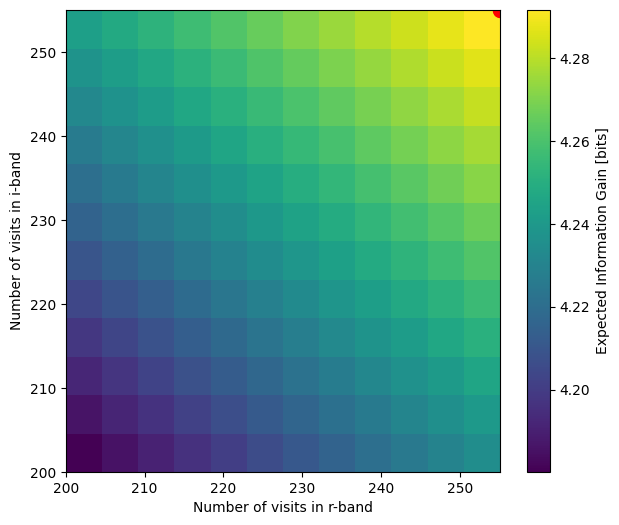

In [8]:
fig, ax = plt.subplots(figsize=(7,6))
I = ax.imshow(designer.EIG.T, origin='lower', extent=designs.extent('n_r')+designs.extent('n_i'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot([best['n_r'], best['n_i']], [best['n_i'], best['n_r']], 'ro', markersize=10)
ax.set(xlabel='Number of visits in r-band', ylabel='Number of visits in i-band');

Let's add a constraint to the number of visits across the bands by restricting it to the fiducial value for LSST.

In [31]:
filters_list = ['u', 'z']
parameters, features, designs = create_grids(
    filters_list, 
    design_step=5, 
    num_parameters=202, 
    num_features=201, 
    constraint=True
)

Constraining the total number of visits to be 270
Grid objects:
parameters: (202,)
features: (201, 201)
designs: (11, 1)


In [32]:
prior = TopHat(parameters.z)
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})

In [33]:
designer = ExperimentDesigner(parameters, features, designs, unnorm_lfunc, lfunc_args={"filters_list": filters_list})
best = designer.calculateEIG(prior)
designer.describe()

GRID           designs [11:n_u, 11:n_z]
GRID          features [201:mag_u, 201:mag_z]
GRID        parameters [202:z]
ARRAY            prior (202,)                           0.0 Mb
ARRAY       likelihood (201, 201, 11, 1, 202)         684.9 Mb
ARRAY         marginal (201, 201, 11, 1)                3.4 Mb
ARRAY               IG (201, 201, 11, 1)                3.4 Mb
ARRAY              EIG (11, 1)                          0.0 Mb


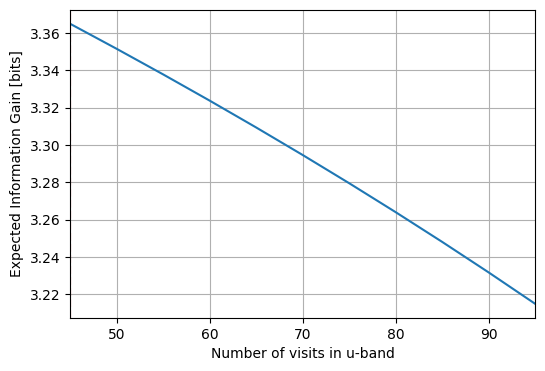

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(getattr(designs, designs.names[0]), designer.EIG)
ax.set(xlabel=f'Number of visits in {filters_list[0]}-band', xlim=designs.extent(designs.names[0]),
       ylabel='Expected Information Gain [bits]')
ax.axvline(best[designs.names[0]], color='r', linestyle='--')
ax.grid();